In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import time, datetime as dt

## Get data

In [4]:
tickers = 'SPY'
start_date = dt.datetime(2004,12,1)
end_date = dt.datetime(2016,11,11)

In [5]:
data = web.DataReader(tickers, 'yahoo', start_date, end_date)

In [6]:
def load_data(data):
    price = data['Adj Close'].to_frame()
    price.columns = ['price']
    price.loc[:,'daily_ret'] = price.price.pct_change(1)
    price.loc[:,'monthly_ret'] = price.price.pct_change(22)
    price.loc[:,'22d_std'] = price.daily_ret.rolling(22).std()
    price.loc[:, 'action'] = 0
    return price

In [7]:
def get_state(xdata, time_step):
    return xdata.iloc[time_step,1:4].fillna(0).values

In [8]:
def sig_to_action(action):
    if action == 0:
        return 100000
    elif action == 1:
        return 0
    elif action == 2:
        return -100000

In [9]:
def get_reward(xdata, time_step):
    reward = xdata.iloc[time_step-1, 4] * xdata.iloc[time_step, 1]
    return reward

### Run game

In [10]:
price = load_data(data)
time_step = 50
state = get_state(price, time_step)
price.tail()

,price,daily_ret,monthly_ret,22d_std,action
Date,,,,,
2016-11-07,213.149994,0.022057,-0.012188,0.006595,0
2016-11-08,214.110001,0.004504,-0.004325,0.006646,0
2016-11-09,216.380005,0.010602,0.001018,0.006947,0
2016-11-10,216.919998,0.002496,0.016352,0.006354,0
2016-11-11,216.419998,-0.002305,0.012681,0.006385,0


In [11]:
get_state(price, time_step)

array([ 0.0086 ,  0.02192,  0.00598])

In [12]:
price.iloc[time_step, 4] = sig_to_action(0)
time_step += 1

In [13]:
get_reward(price, time_step)

-74.519056720456774

In [14]:
price.iloc[time_step, 4] = sig_to_action(2)
time_step += 1

In [15]:
get_reward(price, time_step)

-372.88470988179336

In [16]:
long_sig = price[price.action > 0]
short_sig = price[price.action < 0]

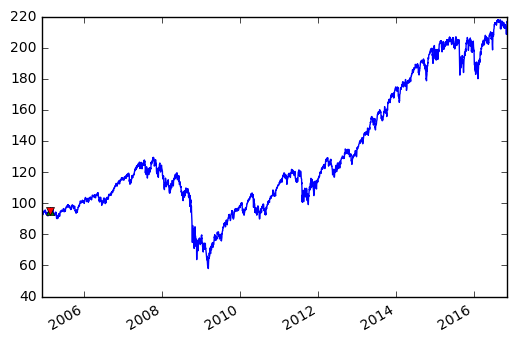

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(price.index, price.price, 'b-')
ax1.plot(long_sig.index, long_sig.price, 'g^')
ax1.plot(short_sig.index, short_sig.price, 'rv')
fig.autofmt_xdate()

### Setting NN

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(150, init='lecun_uniform', input_shape=(3,)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(Dense(150, init='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(3, init='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

Using TensorFlow backend.


In [19]:
def testAlgo(price, epochs):
    status = 1
    time_step = 0
    terminal_step = len(price) - 1
    
    #while game still in progress
    while(status == 1):
        state = get_state(price, time_step)
        qval = model.predict(state.reshape(1,3), batch_size=1)
        action = (np.argmax(qval)) #take action with highest Q-value

        price.iloc[time_step, 2] = sig_to_action(action)
        time_step += 1

        if time_step > terminal_step:
            status = 0        
    
    long_sig = price[price.action > 0]
    short_sig = price[price.action < 0]
    fig, ax1 = plt.subplots()
    ax1.plot(price.index, price.price, 'b-')
    ax1.plot(long_sig.index, long_sig.price, 'g^')
    ax1.plot(short_sig.index, short_sig.price, 'rv')
    fig.autofmt_xdate()
    ax1.set_title("Test Algo after {0} epochs".format(epochs))

### Test Training

In [20]:
import random, timeit

In [21]:
gamma = 0.9 #a high gamma makes a long term reward more valuable
epsilon = 1.0

In [22]:
price = load_data(data)
time_step = 22
terminal_step = len(price) - 1
state = get_state(price, time_step)

qval = model.predict(state.reshape(1,3), batch_size=1)

if (random.random() < epsilon): #choose random action
    action = np.random.randint(0,3) # 3 different action
else: #choose best action from Q(s,a) values
    action = (np.argmax(qval))
    
price.iloc[time_step, 4] = sig_to_action(2)
time_step += 1

reward = get_reward(price, time_step)

new_state = get_state(price, time_step)

newQ = model.predict(new_state.reshape(1,3), batch_size=1)
maxQ = np.max(newQ)

y = np.zeros((1,3))
y[:] = qval[:]

if time_step < terminal_step: #non-terminal state
    update = (reward + (gamma * maxQ))
else: #terminal state
    update = reward
    status = 0

y[0][action] = update
model.fit(state.reshape(1,3), y, batch_size=1, nb_epoch=1, verbose=1)

state = new_state

Epoch 1/1
1/1 [==============================] - 0s - loss: 497718.6875


### Training!

In [23]:
model.compile(loss='mse', optimizer=rms)#reset weights of neural network
gamma = 0.975
epsilon = 1.
batchSize = 40
buffer = 80
replay = [] #stores tuples of (S, A, R, S')

In [ ]:
start_time = timeit.default_timer()

price = load_data(data)
time_step = 22
terminal_step = len(price) - 1
state = get_state(price, time_step)

h = 0
status = 1
#while game still in progress
while(status == 1):
    #We are in state S
    #Let's run our Q function on S to get Q values for all possible actions
    qval = model.predict(state.reshape(1,3), batch_size=1)
    if (random.random() < epsilon): #choose random action
        action = np.random.randint(0,3)
    else: #choose best action from Q(s,a) values
        action = (np.argmax(qval))

    #Take action, observe new state S'
    price.iloc[time_step, 4] = sig_to_action(action)
    time_step += 1

    #Observe reward
    reward = get_reward(price, time_step)
    new_state = get_state(price, time_step)

    #Experience replay storage
    if (len(replay) < buffer): #if buffer not filled, add to it
        replay.append((state, action, reward, new_state))
    else: #if buffer full, overwrite old values
        if (h < (buffer-1)):
            h += 1
        else:
            h = 0
        replay[h] = (state, action, reward, new_state)

        #randomly sample our experience replay memory
        minibatch = random.sample(replay, batchSize)
        X_train = []
        y_train = []
        for memory in minibatch:
            #Get max_Q(S',a)
            old_state, action, reward, new_state = memory
            old_qval = model.predict(old_state.reshape(1,3), batch_size=1)
            newQ = model.predict(new_state.reshape(1,3), batch_size=1)
            maxQ = np.max(newQ)
            y = np.zeros((1,3))
            y[:] = old_qval[:]
            if time_step < terminal_step: #non-terminal state
                update = (reward + (gamma * maxQ))
            else: #terminal state
                update = reward
            
            y[0][action] = update
            X_train.append(old_state.reshape(3,))
            y_train.append(y.reshape(3,))

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=1)
        state = new_state

    if epsilon > 0.1: #decrement epsilon over time
        epsilon -= (1./(terminal_step*1./batchSize*1.))
    
    if time_step > terminal_step: #terminal state
        status = 0

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

Epoch 1/1
40/40 [==============================] - 0s - loss: 134580.9531
Epoch 1/1
40/40 [==============================] - 0s - loss: 183808.2969
Epoch 1/1
40/40 [==============================] - 0s - loss: 156716.1094
Epoch 1/1
40/40 [==============================] - 0s - loss: 188799.0938
Epoch 1/1
40/40 [==============================] - 0s - loss: 153756.0781
Epoch 1/1
40/40 [==============================] - 0s - loss: 151157.1250
Epoch 1/1
40/40 [==============================] - 0s - loss: 206267.3125
Epoch 1/1
40/40 [==============================] - 0s - loss: 197154.2812
Epoch 1/1
40/40 [==============================] - 0s - loss: 143285.2969
Epoch 1/1
40/40 [==============================] - 0s - loss: 158443.7500
Epoch 1/1
40/40 [==============================] - 0s - loss: 158220.5781
Epoch 1/1
40/40 [==============================] - 0s - loss: 146759.4375
Epoch 1/1
40/40 [==============================] - 0s - loss: 170690.0938
Epoch 1/1
40/40 [=====================

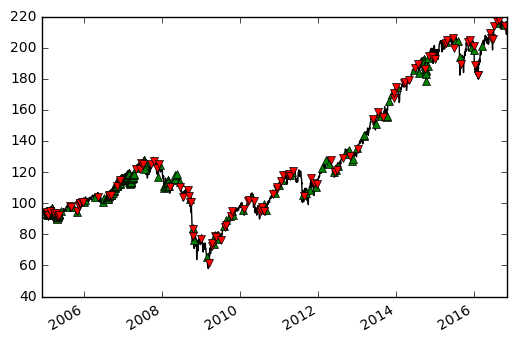

In [48]:
long_sig = price[price.action > 0]
short_sig = price[price.action < 0]
fig, ax1 = plt.subplots()
ax1.plot(price.index, price.price, 'k-')
ax1.plot(long_sig.index, long_sig.price, 'g^')
ax1.plot(short_sig.index, short_sig.price, 'rv')
fig.autofmt_xdate()

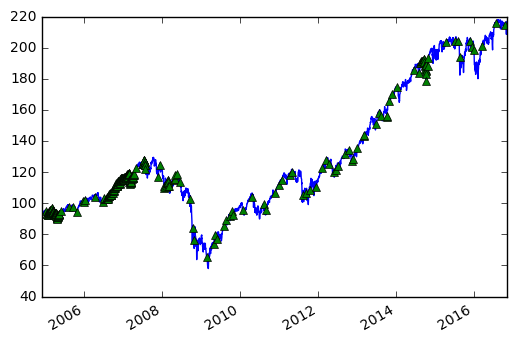

In [34]:
long_sig = price[price.action > 0]
short_sig = price[price.action < 0]
fig, ax1 = plt.subplots()
ax1.plot(price.index, price.price, 'b-')
ax1.plot(long_sig.index, long_sig.price, 'g^')
#ax1.plot(short_sig.index, short_sig.price, 'rv')
fig.autofmt_xdate()

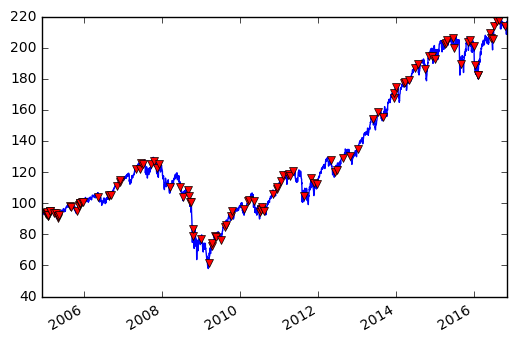

In [35]:
long_sig = price[price.action > 0]
short_sig = price[price.action < 0]
fig, ax1 = plt.subplots()
ax1.plot(price.index, price.price, 'b-')
#ax1.plot(long_sig.index, long_sig.price, 'g^')
ax1.plot(short_sig.index, short_sig.price, 'rv')
fig.autofmt_xdate()